# Demonstrate functions dealing with em follow-up

## new events from gracedb

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# credentials
import yaml
with open('../config/Credentials.yaml', 'r') as file:
    credentials = yaml.safe_load(file)
fritz_token = credentials['fritz_token']
allocation = credentials['allocation']
kowalski_username = credentials['kowalski_username']
kowalski_password = credentials['kowalski_password']
github_token = credentials['github_token']
zfps_email = credentials['zfps_email']
zfps_userpass = credentials['zfps_userpass']
zfps_auth_username = credentials['zfps_auth']['username']
zfps_auth_password = credentials['zfps_auth']['password']

In [4]:
# get events from gracedb that we haven't already saved

from flares_utils.new_events_utils import GetSuperevents
params = GetSuperevents(path_data='../data', 
                        event_source='gracedb',
                        mlp_modelpath='../utils/mlp_model.sav',
                        observing_run='O4c',
                        retrieve_all=False).get_new_events()

19 significant superevents in O4c
0 new events to process (cut 3 low prob bbh events)


In [6]:
# check the trigger status on fritz and check if we handled the event correctly

eventid = [x[0] for x in params]
dateid = [x[12] for x in params]
a90 = [x[16] for x in params]
far = [x[9] for x in params]
mass = [x[22] for x in params]

from flares_utils.new_events_utils import Fritz
trigger_status = Fritz(eventid, dateid, a90, far, mass, allocation, fritz_token).get_trigger_status()

0 errors, 0 correct, 0 inspect


In [7]:
# compile event information and save to the dictionary of events

from flares_utils.new_events_utils import NewEventsToDict
df = NewEventsToDict(params, trigger_status, path_data='../data', check_before_run=False).save_data()
df

No new events to add


In [10]:
# default arguments set at contour=90, mindec=-90

eventid = [x[0] for x in params]
skymap_str = [x[18] for x in params]
zmin = [x[19] for x in params]
zmax = [x[20] for x in params]

from flares_utils.new_events_utils import KowalskiCrossmatch
crossmatch = KowalskiCrossmatch(eventid, 
                                skymap_str, 
                                dateid, 
                                zmin, 
                                zmax, 
                                path_data='../data',
                                testing=True, 
                                kowalski_username=kowalski_username,
                                kowalski_password=kowalski_password)
matches = crossmatch.get_crossmatches()

0 events are missing crossmatch: []
Crossmatching 0 events: []


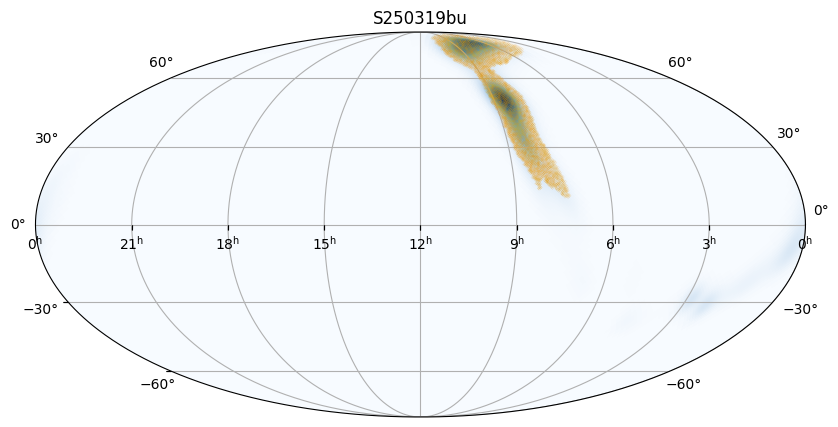

In [3]:
from flares_utils.new_events_utils import PlotSkymap
PlotSkymap(gracedbid='S250319bu', path_data='../data', observing_run='O4c', catalog='agn_catnorth').plot(show_agn=True)

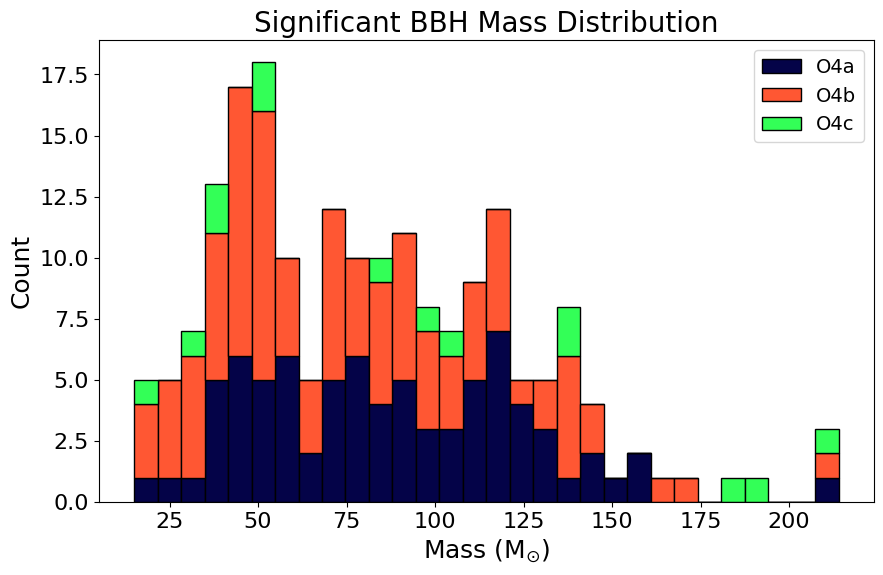

In [18]:
from flares_utils.new_events_utils import VisualizePop
VisualizePop(path_data='../data', observing_run=['O4a', 'O4b', 'O4c']).plot_masses()

In [20]:
from flares_utils.new_events_utils import PushEventsPublic
summary_events = PushEventsPublic(path_data='../data',
                                  github_token=github_token,
                                  observing_run='O4c',
                                  testing=True)

df, priority, trigger_df, error_triggers = summary_events.format_and_push()

2 O4c events with FAR > 10 and mass > 60 and area < 1000 sq deg


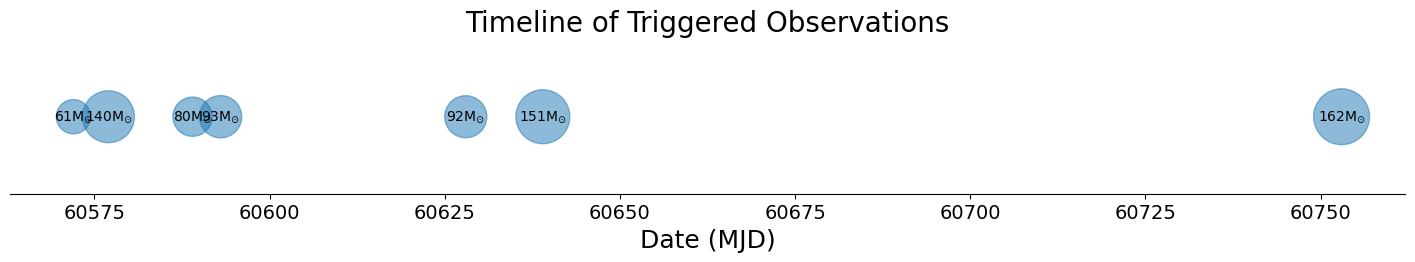

In [21]:
summary_events.plot_trigger_timeline()

# ZTF forced photometry service

In [4]:
# check photometry status

from flares_utils.photometry_utils import PhotometryStatus
PhotometryStatus(observing_run='O4c', path_data='../data').show_status()

12 / 14 events in O4c are not priority


,ID,Date last zfps,Status,Trigger
0,S250319bu,2025-04-23 00:06:59.003,update ZFPS,True
1,S250204ax,,needs ZFPS,


413 / 23880 dataframes for 24284 Catnorth sources are empty


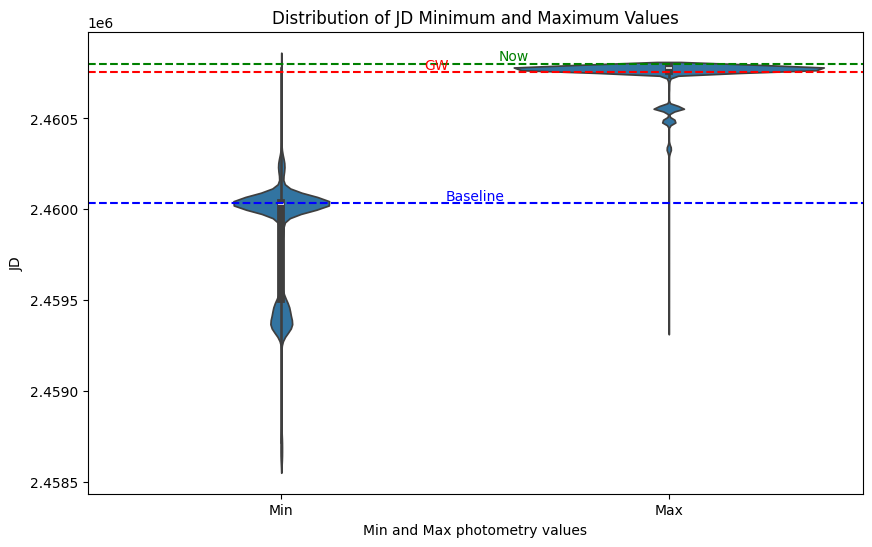

In [5]:
# check our photometry coverage

from flares_utils.photometry_utils import PlotPhotometry

PlotPhotometry(observing_run='O4c', graceid='S250319bu', path_data='../data').plot_photometry_dates()

In [27]:
from flares_utils.photometry_utils import PhotometryCoords
ra, dec, jd, num_agn = PhotometryCoords(action='new', 
                               graceid='S250319bu', 
                               catalog=['catnorth'], 
                               verbose=True,
                               path_data='../data',
                               observing_run='O4c').get_photometry_coords()

404 / 24284 total coords dont have photometry
Submit in 1 batches


In [30]:
from flares_utils.photometry_utils import GetPhotometry

submit = GetPhotometry(ra, 
              dec, 
              jd, 
              graceid='S250319bu', 
              auth_username=zfps_auth_username, 
              auth_password=zfps_auth_password, 
              email=zfps_email, 
              userpass=zfps_userpass,
              observing_run='O4c', 
              path_data='../data',
              testing=True).submit()

Testing mode - no submission
Submitted 404 AGN in 1 batches at 2025-05-01 00:09:14.091


In [46]:
from flares_utils.photometry_utils import SavePhotometry

date_submitted=submit[0]
num_batches=submit[2]

SavePhotometry(graceid='S250319bu',
               action='new', 
               path_data='../data', 
               submission_date=date_submitted,
               num_batches_submitted=num_batches,
               testing=True,
               email=zfps_email,
               userpass=zfps_userpass,
               auth_username=zfps_auth_username,
               auth_password=zfps_auth_password).save()

Script executed normally and queried the ZTF Batch Forced Photometry database.

0 coords found
Returned 0 batches for 1 submitted


## rolling window heuristic for flares

In [48]:
from flares_utils.flares_utils import FlarePreprocessing
AGN = FlarePreprocessing(graceid='S241114y', 
                         path_data='../data', 
                         observing_run='O4b').process_for_flare()

found 3819 AGN


In [49]:
# default arguments window_size_before=50, window_size_after=25, baseline_years=2

from flares_utils.flares_utils import RollingWindowStats
stats = RollingWindowStats(graceid='S241114y', 
                           agn=AGN, 
                           path_data='../data',
                           window_size_before=50, 
                           window_size_after=25, 
                           baseline_years=2, 
                           observing_run='O4b').get_rolling_window_stats()

In [50]:
# k_mad defines the scalar on the mean absolute deviations that a point in the GW window must be brighter than,
# percent defines the percentage of baseline medians that must meet this criteria

from flares_utils.flares_utils import RollingWindowHeuristic
g, r, i, gr, gri = RollingWindowHeuristic(graceid='S241114y', 
                                          agn=AGN, 
                                          rolling_stats=stats, 
                                          path_data='../data',
                                          percent=0.6, 
                                          k_mad=3, 
                                          save=False,
                                          observing_run='O4b').get_flares()

in g,r,i we find 1066,1471,427 candidates
1908 unique flares across all colors
707 AGN have flares in g and r filters
221 AGN have flares in g, r, and i filters
335 / 3819 have no observations in any color in 200 day post GW period
136 / 3819 have no observations in any color before the GW detection


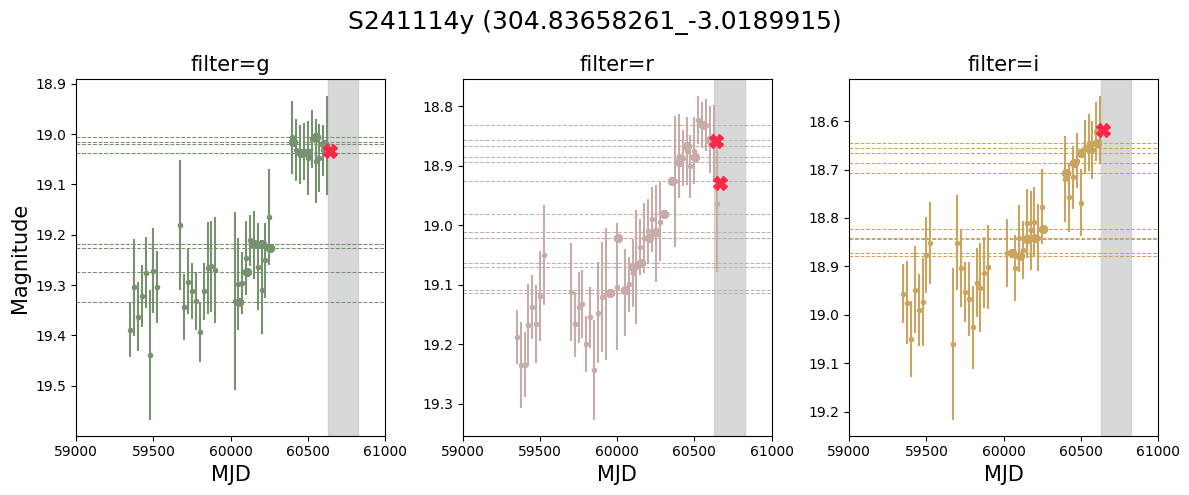

[None]

In [51]:
# plot given the values defined above
from flares_utils.flares_utils import Plotter

# plot from an index:
plot_index = gri[0:1].tolist()
[Plotter(index_to_plot=[i], 
         color_to_plot='all', 
         agn=AGN, 
         rolling_stats=stats, 
         graceid='S241114y', 
         path_data='../data',
         observing_run='O4b').show_plots() for i in plot_index]

# plot matches from a fully processed graceid

In [6]:
# plot given only a graceid
#first load the data, wont plot heuristic because do not save stats

graceid = 'S250319bu'

from flares_utils.flares_utils import FlarePreprocessing
from flares_utils.flares_utils import Plotter

AGN = FlarePreprocessing(graceid=graceid, 
                         path_data='../data',
                         observing_run='O4c').process_for_flare()

found 23880 AGN


1881 AGN have flares in gr band(s)


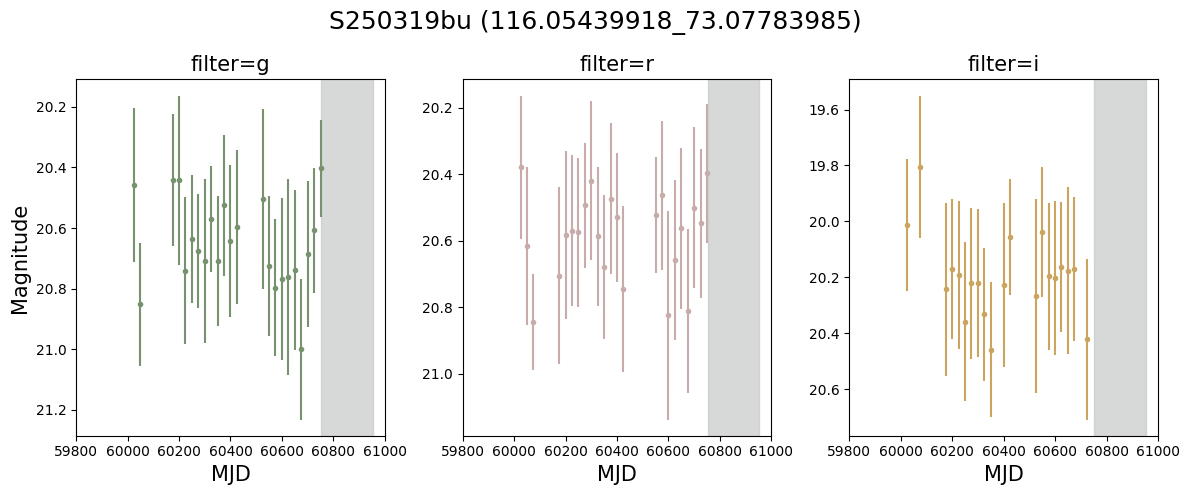

In [39]:
# if flares_from_gracid argument is provided, will only plot AGN with flares in those bands

index_to_plot = [32]

Plotter(index_to_plot=index_to_plot, 
         color_to_plot='all', 
         agn=AGN, 
         rolling_stats=None, 
         graceid=graceid, 
         path_data='../data',
         observing_run='O4c',
         flares_from_graceid='gr').show_plots()